battery json data  convert to matrix and input to CNN for train

In [1]:
#计算真实的SOC值
from sklearn import preprocessing 
from scipy.io import loadmat, whosmat
import numpy as np
import datetime
import json
import os

def json_load(dictonary):
    with open(dictonary) as f:
        data = json.load(f)
    return data

#cycle为行数，循环读取一行数据，对一行数据里面的voltage and current求平均
def batteryData2array(battery_data):
    vol_sum = 0
    cur_sum = 0
    temp_sum=0
    battery_array = []
    for cycle in battery_data.keys():
        battery_vols = battery_data[cycle]["voltage_battery"]
        battery_curs = battery_data[cycle]["current_battery"]
        battery_temps=battery_data[cycle]["temp_battery"]
#         print(battery_temps)
        for battery_vol in battery_vols:
            vol_sum += float(battery_vol)
        for battery_cur in battery_curs:
            cur_sum += float(battery_cur)
        for battery_temp in battery_temps:
            temp_sum += float(battery_temp)
        #for voltage and current average  & battery_vols,battery_curs,battery_temps's len is equal
        num = len(battery_vols)
        vol_aver = vol_sum / num
        cur_aver = cur_sum / num
        temp_aver=temp_sum/num
        vol_sum = 0
        cur_sum = 0
        temp_sum=0
#         battery_array.append([abs(vol_aver),abs(cur_aver),abs(temp_aver)])
        battery_array.append([vol_aver,cur_aver,temp_aver])
#         battery_array.append([vol_aver,cur_aver])
    return battery_array

# get battery's true soc
def  getTrueSOC(battery_discharge_data):
    batteryCapcity=2
    soc_dict=[]
    for cycle in battery_discharge_data.keys():
        cycleCapacity=battery_discharge_data[cycle]["Capacity"]
        soc_true=cycleCapacity[0]/batteryCapcity
        soc_dict.append(soc_true)
    return soc_dict

In [2]:
# 获取得到总的图像矩阵  6维特征向量
if __name__=="__main__":
    #get the discharge and charge json data
    discharge=r'/home/zsj/yangHong/battery experiment/jsonData/B0005_discharge.json'
    discharge_data =json_load(discharge)
    charge=r'/home/zsj/yangHong/battery experiment/jsonData/B0005_charge.json'
    charge_data = json_load(charge)
    
    #get the true soc data
    
    true_soc=getTrueSOC(discharge_data)
    
    #get the  discharge and charge array data
    discharge_array = batteryData2array(discharge_data)
    charge_array = batteryData2array(charge_data)
    if len(discharge_array) < len(charge_array):
        arr_len = len(discharge_array)
    else:
        arr_len = len(charge_array)
#     arr_len = len(discharge_array)
    discharge_matrix = np.array(discharge_array[0:arr_len])
    charge_matrix = np.array(charge_array[0:arr_len])
#     hstack()在行上合并
    all = np.hstack((charge_matrix,discharge_matrix))
    
    #matrix to standardization
    data_standardization = preprocessing.StandardScaler()
    battery_scaled = data_standardization.fit_transform(all)
    print(battery_scaled.shape)
    print(np.array(true_soc).shape)

(168, 6)
(168,)


In [3]:
# 获取得到总的图像矩阵  3维特征向量
if __name__=="__main__":
    #get the discharge and charge json data
    discharge=r'/home/zsj/yangHong/battery experiment/jsonData/B0005_discharge.json'
    discharge_data =json_load(discharge)
    #get the true soc data
    
    true_soc=getTrueSOC(discharge_data)
    
    #get the  discharge and charge array data
    discharge_array = batteryData2array(discharge_data)
    arr_len = len(discharge_array)
    discharge_matrix = np.array(discharge_array[0:arr_len])
    
    print(discharge_matrix.shape)
    print(np.array(true_soc).shape)
    discharge_matrix=preprocessing.scale(discharge_matrix)
    

(168, 3)
(168,)


In [4]:
#循环切片形成数据集
x=[];y=[]
x_train=[];y_train=[];x_test=[];y_test=[]
flag=0


# 获取得到x,y的数据集
for i in range(len(discharge_matrix.tolist())):
    #首先截取0--31这段的长度，叠加+1循环得到x
    bataery_data_training=discharge_matrix[flag:flag+8,:]
#     print(bataery_data_training.shape)
    if(len(bataery_data_training)<8):
        break
    else:
        #进行转置，形成3*T的时间维度
        x.append(bataery_data_training)
    flag+=1
y=true_soc[7:]

# 获取得到训练集，测试集
VALIDATION_SPLIT=0.9
x_validation_samples = int( VALIDATION_SPLIT* len(x))
y_validation_samples = int( VALIDATION_SPLIT*len(y))
x_train=np.array(x[:x_validation_samples])
x_test=np.array(x[x_validation_samples:])
y_train=np.array(y[:y_validation_samples])
y_test=np.array(y[y_validation_samples:])
print("x_train's shape is:", x_train.shape,"，y_train's shape is:",y_train.shape)
print("x_test's shape is:",x_test.shape,"，y_test's shape is:",y_test.shape)

x_train's shape is: (144, 8, 3) ，y_train's shape is: (144,)
x_test's shape is: (17, 8, 3) ，y_test's shape is: (17,)


In [5]:
#写一个LossHistory类，保存loss和mae
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Convolution2D
from keras import backend as k
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('mean_absolute_error'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_mean_absolute_error'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('mean_absolute_error'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_mean_absolute_error'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # mae
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train mae')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_mean_absolute_error
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val mean absolute error')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('mae-loss')
        plt.legend(loc="upper right")
        plt.show()

Using TensorFlow backend.


In [6]:
#使用cnn训练的模型
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Convolution2D
from keras import backend as k
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

num=1
img_rows, img_cols =x_train.shape[1],x_train.shape[2]
if K.image_dim_ordering() == 'th':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
# print(x_train.shape,x_test.shape)
# print(y_train.shape)
# keras序贯模型搭建CNN
# model building
model = Sequential()
#convolutional layer with rectified linear unit activation
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu',
                 input_shape=input_shape,padding="same"))
#32 convolution filters used each of size 3x3
#again
model.add(Conv2D(32, (3,3), activation='relu',padding="same"))
#64 convolution filters used each of size 3x3
#choose the best features via pooling
model.add(MaxPooling2D(pool_size=(2, 2)))

#randomly turn neurons on and off to improve convergence
# model.add(Dropout(0.25))
#flatten since too many dimensions, we only want a classification output
model.add(Flatten())
#fully connected to get all relevant data
model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.25))
#one more dropout for convergence' sake :) 
#output a softmax to squash the matrix into output probabilities
model.add(Dense(num, activation='sigmoid'))

#Adaptive learning rate (adaDelta) is a popular form of gradient descent rivaled only by adam and adagrad
#categorical ce since we have multiple classes (10) 
# model.compile(loss=keras.losses.sparse_categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])
#回归问题评价指标使用mae
model.compile(loss='mse', optimizer="sgd", metrics=["mae"])


batch_size =64
num_epoch = 32
#model training
history = LossHistory()
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epoch,
          verbose=1,validation_split=0.1,callbacks=[history])

mse_score,mae_score= model.evaluate(x_test, y_test, verbose=0)
print('Test MSE Score:%10.3f %%'% (mse_score*100)) 
print('Test MAE Score:%10.3f %%'% (mae_score*100))


#test
# out = model.predict(x_prd, batch_size=1)
# #plot prediction data
 
# ax.plot(x_prd, out, 'k--', lw=4)

# ax.set_xlabel('Measured')
# ax.set_ylabel('Predicted')
# plt.show()
# figures(hist)


# Save the model
# serialize model to JSON
# model_digit_json = model.to_json()
# with open("model_digit.json", "w") as json_file:
#     json_file.write(model_digit_json)
# # serialize weights to HDF5
# model.save_weights("model_.h5")
# print("Saved model to disk")

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 129 samples, validate on 15 samples
Epoch 1/32
129/129 [==============================] - 0s - loss: 0.0803 - mean_absolute_error: 0.2796 - val_loss: 0.0401 - val_mean_absolute_error: 0.2002
Epoch 2/32
129/129 [==============================] - 0s - loss: 0.0759 - mean_absolute_error: 0.2717 - val_loss: 0.0359 - val_mean_absolute_error: 0.1894
Epoch 3/32
129/129 [==============================] - 0s - loss: 0.0721 - mean_absolute_error: 0.2647 - val_loss: 0.0330 - val_mean_absolute_error: 0.1817
Epoch 4/32
129/129 [==============================] - 0s - loss: 0.0687 - mean_absolute_error: 0.2582 - val_loss: 0.0304 - val_mean_absolute_error: 0.1743
Epoch 5/32
129/129 [==============================] - 0s - loss: 0.0645 - mean_absolute_error: 0.2502 - val_loss: 0.0277 - val_mean_absolute_error: 0.1663
Epoch 6/32
129/129 [==============

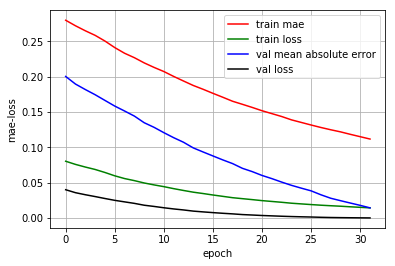

In [7]:
#绘制mae-loss曲线
history.loss_plot('epoch')

In [8]:
#evaluate返回的指标参数含义 loss为mse
model.metrics_names

['loss', 'mean_absolute_error']

In [9]:
pred=model.predict(x_test, batch_size=16, verbose=0)
print(pred)

[[0.6498121 ]
 [0.64801705]
 [0.65411407]
 [0.6521142 ]
 [0.6448701 ]
 [0.6445209 ]
 [0.6483356 ]
 [0.64788735]
 [0.64949775]
 [0.651314  ]
 [0.6543293 ]
 [0.6536725 ]
 [0.65576094]
 [0.658318  ]
 [0.6582276 ]
 [0.661175  ]
 [0.6613672 ]]


range(0, 168) 
-----------------------： range(152, 169)


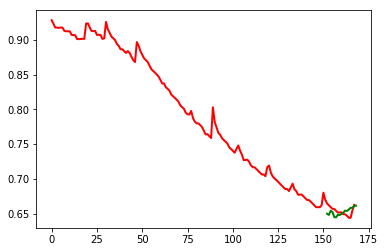

In [10]:
import pandas as pd # 导入pandas库用来处理csv文件
import matplotlib.pyplot as plt # 导入matplotlib.pyplot并用plt简称

x_true_soc=range(len(true_soc))
start=x_train.shape[0]+x_train.shape[1]
x_test_soc=range(start,start+pred.shape[0])
print(x_true_soc,"\n-----------------------：",x_test_soc)
plt.plot(x_true_soc, true_soc, linewidth=2.0, color='r',label="True SOC")#线的宽度为2.0，颜色为红色
plt.plot(x_test_soc, pred, linewidth=2.0, color='green',label="Test SOC")#线的宽度为2.0，颜色为红色
plt.show()#显示图像
